In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

In [2]:
symbol = input("enter symbol here : ")

##### Fetch Live stock data 

In [ ]:
import yfinance as yf

print(f"Fetching data for '{symbol}' using yfinance...")

try:
    # 2. Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # 3. Fetch historical market data 
    data = sym_data.history(period="60d", interval="5m")

    data = data.reset_index()  # Reset index to make 'Datetime' a column
    # The column name after reset_index depends on the yfinance version,
    # it could be 'Datetime' or 'index'. We'll handle 'Datetime'.
    if "Datetime" in data.columns:
    #     # Format the 'Datetime' column to 'YYYY-MM-DD HH:MM'
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")
    elif "index" in data.columns:
        data = data.rename(columns={"index": "Datetime"})
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")

    # We now have the 'Datetime' column to include.
    data = data[["Datetime", "Open", "High", "Low", "Close"]]

    # 7. Display the final data
    print("\nHere are the last 5 data points with the formatted Datetime column:")
    print(data.tail())

except Exception as e:
    print(f"\nAn error occurred: {e}")

Fetching data for '^NSEI' using yfinance...

Here are the last 5 data points with the formatted Datetime column:
              Datetime          Open          High           Low  \
4420  2025-08-29 15:05  24446.800781  24450.800781  24427.199219   
4421  2025-08-29 15:10  24429.449219  24431.000000  24406.550781   
4422  2025-08-29 15:15  24406.750000  24418.699219  24405.449219   
4423  2025-08-29 15:20  24412.199219  24425.000000  24407.750000   
4424  2025-08-29 15:25  24413.750000  24444.900391  24413.750000   

             Close  Volume  
4420  24429.199219       0  
4421  24406.750000       0  
4422  24411.199219       0  
4423  24411.949219       0  
4424  24433.650391       0  


##### Neccesary Data pre-processing steps 

In [4]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T)

summary statistics  
          count          mean         std           min           25%  \
Open    4425.0  24996.086471  313.635076  24345.199219  24758.500000   
High    4425.0  25004.949087  312.744403  24348.449219  24770.250000   
Low     4425.0  24986.613561  314.361670  24337.949219  24742.800781   
Close   4425.0  24995.809371  313.443163  24344.449219  24758.400391   
Volume  4425.0      0.000000    0.000000      0.000000      0.000000   

                 50%           75%           max  
Open    24988.349609  25185.250000  25660.949219  
High    24995.500000  25193.800781  25664.849609  
Low     24980.400391  25175.750000  25639.900391  
Close   24987.949219  25185.050781  25647.599609  
Volume      0.000000      0.000000      0.000000  


##### Stock Price Visualization 

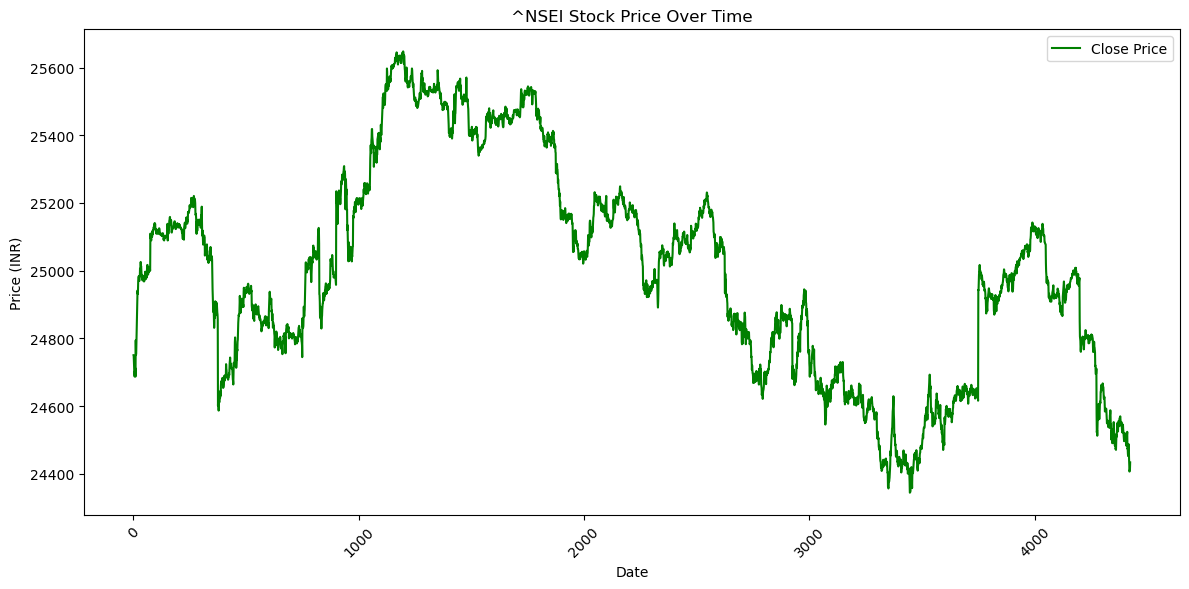

In [5]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price" , color="green")
plt.title(f"{symbol} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

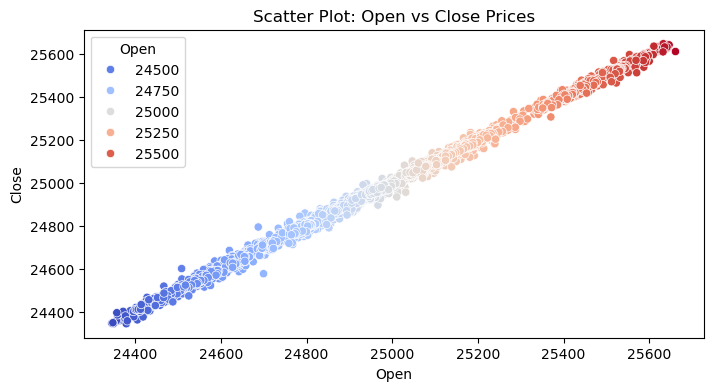

In [6]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

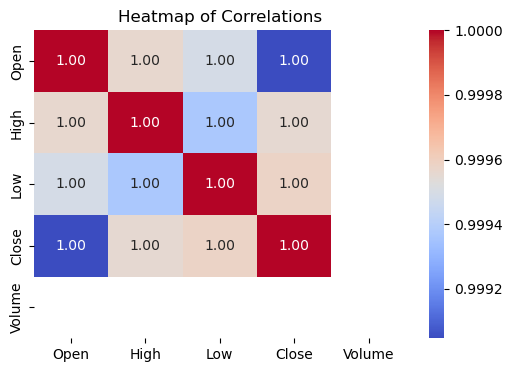

In [7]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [8]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): 0.13342723817283664
Skewness (Open): 0.13365518788158307
Skewness (High): 0.13624054278320094
Skewness (Low): 0.131600139042689
Skewness (Volume): nan


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [9]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [10]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [11]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


              Datetime      Open     High       Low     Close  Volume  Trend
4420  2025-08-29 15:05  24446.80  24450.8  24427.20  24429.20       0      0
4421  2025-08-29 15:10  24429.45  24431.0  24406.55  24406.75       0      1
4422  2025-08-29 15:15  24406.75  24418.7  24405.45  24411.20       0      1
4423  2025-08-29 15:20  24412.20  24425.0  24407.75  24411.95       0      1
4424  2025-08-29 15:25  24413.75  24444.9  24413.75  24433.65       0      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [12]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close", "Volume"]])

Step 2: Create sequences(timesteps)

In [13]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


Step 3: Train-test split (no shuffle)

In [14]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (3492, 60, 5), (3492,)
Testing data shape: (873, 60, 5), (873,)


Step 4: LSTM model (Keras - RNN variant) 

In [15]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.0521 - val_loss: 8.4534e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0039 - val_loss: 7.8214e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0031 - val_loss: 7.7614e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0032 - val_loss: 9.5029e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0028 - val_loss: 7.3146e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0024 - val_loss: 7.5350e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0029 - val_loss: 9.5907e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0024 - val_loss: 5.9821e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0023 - val_loss: 5.7455e-04
Epo

Model evaluation metrics

In [16]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [17]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 19.870351597433768
MAE: 10.729944784014274
R2 score: 0.9902079750153674


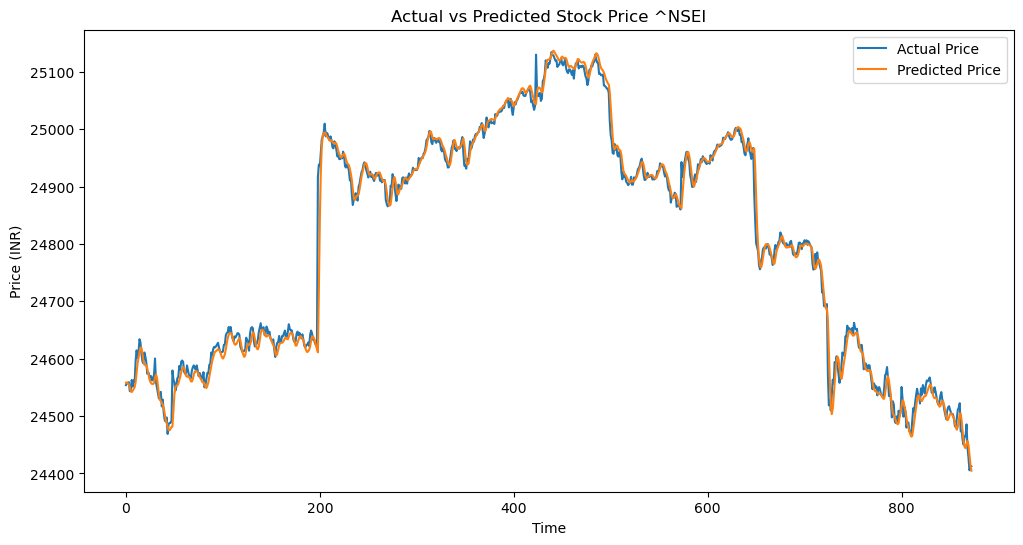

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price {symbol}")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

In [19]:
# --- 1. User Input for Forecast Period ---
try:
    forecast_minutes = int(input("Enter the number of minutes to forecast (e.g., 15, 30, 60): "))
    if forecast_minutes <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number. Defaulting to 30 minutes.")
    forecast_minutes = 30

Invalid input. Please enter a positive number. Defaulting to 30 minutes.


In [25]:
# Since data interval is 5 minutes, calculate the number of steps to predict
future_steps = int(forecast_minutes / 5)
print(
    f"Forecasting for {forecast_minutes} minutes, which is {future_steps} 5-minute steps."
)


# --- 2. Corrected Forecasting Logic ---
lookback = time_steps  # time_steps = 60 from your training cell

# Start with the last 'lookback' steps from your scaled dataset (with all 5 features)
last_sequence = scaled_data[-lookback:].copy()
forecast_predictions = []

for _ in range(future_steps):
    # Reshape the sequence to be a single sample with 5 features
    X_input = np.reshape(last_sequence, (1, lookback, 5))

    # Predict the next 5-minute interval's closing price (scaled)
    pred_scaled = model.predict(X_input)[0, 0]

    # Store the scaled prediction
    forecast_predictions.append(pred_scaled)

    # Create the next input row for the sequence
    # Use the predicted close price and carry over the other features from the last step
    next_input_row = last_sequence[-1].copy()  # Get the last row of 5 features
    next_input_row[3] = pred_scaled  # Update the 'Close' price feature (index 3)

    # Append the new row and remove the oldest to maintain the sequence length
    last_sequence = np.append(last_sequence[1:], [next_input_row], axis=0)

# --- 3. Inverse Transform and Display Forecast ---
# Create a dummy array with the same number of features to inverse transform the predictions
forecast_transformed = np.zeros((len(forecast_predictions), 5))
# Place the scaled predictions into the 'Close' price column (index 3)
forecast_transformed[:, 3] = forecast_predictions

# Inverse transform to get the actual price values
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, 3]
# Ensure last_timestamp is a datetime
last_timestamp = pd.to_datetime(data["Datetime"].iloc[-1])

# Option 1: Using list + DateOffset
future_timestamps = [
    last_timestamp + pd.DateOffset(minutes=5 * (i + 1)) for i in range(future_steps)
]

# Option 2 (cleaner): Using pd.date_range
future_timestamps = pd.date_range(
    start=last_timestamp + pd.Timedelta(minutes=5),
    periods=future_steps,
    freq="5min",  # 5-minute frequency
)
forecast_df = pd.DataFrame(
    {"Timestamp": future_timestamps, "Predicted Close": forecast_prices}
)

print(f"\nPredicted Closing Prices for the Next {forecast_minutes} Minutes:")
print(forecast_df)
# --- 4. Enhanced Visualization ---
# plt.figure(figsize=(15, 7))

# Plot recent historical data using the actual datetime index
# plt.plot(
#     data["Datetime"].iloc[-200:],
#     data["Close"].iloc[-200:],
#     label="Historical Close Price",
#     color="blue",
# )

# Plot the forecasted data with future timestamps
# plt.plot(
#     forecast_df["Timestamp"],
#     forecast_df["Predicted Close"],
#     label="Forecasted Close Price",
#     color="red",
#     marker="o",
#     linestyle="--",
# )

# plt.title(f"Actual vs. Forecasted Stock Price for {symbol}")
# plt.xlabel("Date and Time")
# plt.ylabel("Price (INR)")
# plt.legend()
# plt.grid(True)

# Format the x-axis to show dates and times nicely
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gcf().autofmt_xdate()  # Rotates the dates for better readability

# plt.show()

Forecasting for 30 minutes, which is 6 5-minute steps.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Predicted Closing Prices for the Next 30 Minutes:
            Timestamp  Predicted Close
0 2025-08-29 15:30:00     24404.347446
1 2025-08-29 15:35:00     24406.632415
2 2025-08-29 15:40:00     24409.296354
3 2025-08-29 15:45:00     24411.441627
4 2025-08-29 15:50:00     24412.799054
5 2025-08-29 15:55:00     24413.424716
